# UCI Yacht Hydrodynamics Model-Driven Improvability
In this tutorial we show how to use the `kxy` package to quantify the extent to which a trained regression model can be improved without resorting to new datasets.

We use the UCI Yacht Hydrodynamics dataset.

In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

# Required imports
import pandas as pd
import kxy

In [2]:
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/'\
                 '00243/yacht_hydrodynamics.data', sep='[ ]{1,2}',\
                 names=['Longitudinal Position', 'Prismatic Coeefficient',\
                        'Length-Displacement', 'Beam-Draught Ratio',\
                        'Length-Beam Ratio', 'Froude Number',\
                        'Residuary Resistance'])

## Basic Model 1: Linear Regression
We begin by training a simple linear regression model.

In [3]:
# Learning (Basic Linear Regression)
from sklearn.linear_model import LinearRegression
# Training
label_column = 'Residuary Resistance'
train_size = 200
train_df = df.iloc[:train_size]
x_train = train_df[['Longitudinal Position', 'Prismatic Coeefficient',\
                        'Length-Displacement', 'Beam-Draught Ratio',\
                        'Length-Beam Ratio', 'Froude Number']].values
y_train = train_df[label_column].values
model = LinearRegression().fit(x_train, y_train)

# Testing
test_df = df.iloc[train_size:]
x_test = test_df[['Longitudinal Position', 'Prismatic Coeefficient',\
                        'Length-Displacement', 'Beam-Draught Ratio',\
                        'Length-Beam Ratio', 'Froude Number']].values
y_test = test_df[label_column].values

# Out-of-sample predictions
predictions = model.predict(x_test)
test_df['Prediction'] = predictions

# In-sample predictions
in_sample_predictions = model.predict(x_train)
train_df['Prediction'] = in_sample_predictions

# Out-of-sample accuracy (R^2)
'Linear Regression Out-Of-Sample R^2: %.3f' % (model.score(x_test, y_test))

'Linear Regression Out-Of-Sample R^2: 0.648'

In [4]:
print('''
Model Parameters:
* Longitudinal Position: %.4f,
* Prismatic Coeefficient: %.4f,
* Length-Displacement: %.4f,
* Length-Displacement: %.4f,
* Length-Beam Ratio: %.4f,
* Froude Number: %.4f.''' % tuple(list(model.coef_)))


Model Parameters:
* Longitudinal Position: 0.1725,
* Prismatic Coeefficient: -32.0069,
* Length-Displacement: 1.9683,
* Length-Displacement: -0.9958,
* Length-Beam Ratio: -2.6162,
* Froude Number: 118.0419.


In [5]:
print('''
Model Parameters (Adjusted For Std):
* Longitudinal Position: %.4f,
* Prismatic Coeefficient: %.4f,
* Length-Displacement: %.4f,
* Length-Displacement: %.4f,
* Length-Beam Ratio: %.4f,
* Froude Number: %.4f.''' % tuple(list(model.coef_*x_train.std(axis=0))))


Model Parameters (Adjusted For Std):
* Longitudinal Position: 0.2288,
* Prismatic Coeefficient: -0.4150,
* Length-Displacement: 0.4872,
* Length-Displacement: -0.5807,
* Length-Beam Ratio: -0.6904,
* Froude Number: 11.9654.


### Improvability Analysis Model 1

In [6]:
# Improvability analysis
improvability_analysis = train_df.kxy.model_driven_improvability(\
    label_column, 'Prediction', problem_type='regression')
improvability_analysis

[====================================================================================================] 100% ETA: 0s   


,Lost R-Squared,Lost Log-Likelihood Per Sample,Lost RMSE,Residual R-Squared,Residual Log-Likelihood Per Sample,Residual RMSE
0,0.00,0.00,0.00,0.02,-3.53,8.49


#### Column Meaning

* `Lost R^2`: The $R^2$ that has been irreversibly lost by the trained model. That is, the difference between the highest $R^2$ that could be achieved from raw inputs, and the highest $R^2$ that could be achieved from model predictions.
* `Lost True Log-Likelihood Per Sample`: The true log-likelihood per sample that has been irreversibly lost by the trained model. That is, the difference between the highest log-likelihood per sample that could be achieved from raw inputs, and the highest log-likelihood per sample that could be achieved from model predictions.
* `Residual R^2`:  The highest $R^2$ that can be achieved when trying to predict model residuals using inputs.
* `Residual True Log-Likelihood Per Sample`: The highest log-likelihood per sample that can be achieved when trying to predict model residuals using inputs.

### Interpretation Analysis Model 1

Judging by the low values of `Lost R^2` and `Lost True Log-Likelihood Per Sample`, the linear regression model doesn't seem to have resulted in information loss. Most of the value in using inputs to predict the label are captured in the model predictions. 

However, given the high `Residual R^2`, the trained model itself doesn't seem to be the most accurate.

Let's another simple model.

In [7]:
train_df.kxy.variable_selection(label_column, problem_type='regression')

[====================================================================================================] 100% ETA: 0s   


,Variable,Running Achievable R-Squared,Running Achievable RMSE
Selection Order,,,
1,Prediction,1.00,0.00
2,Froude Number,1.00,0.00
3,Beam-Draught Ratio,1.00,0.00
4,Prismatic Coeefficient,1.00,0.00
5,Length-Displacement,1.00,0.00
6,Longitudinal Position,1.00,0.00
7,Length-Beam Ratio,1.00,0.00


Our variable selection analysis suggests that the `Froude Number` variable is, by far, the most important. Let's try traning a simple univariate nonlinear regression model, namely an RBF-Gaussian Process regression.

## Basic Model 2: Linear Regression

In [8]:
import GPy # pip install GPy
x_train = train_df[['Froude Number']].values
x_test = test_df[['Froude Number']].values
kernel = GPy.kern.RBF(input_dim=1)
gp_model = GPy.models.GPRegression(x_train, y_train[:, None], kernel)
gp_model.optimize()
gp_predictions = gp_model.predict(x_test)[0].flatten()

# Out-of-sample accuracy (R^2)
ss_res = ((gp_predictions-y_test)**2).sum()
ss_tot = ((y_test-y_test.mean())**2).sum()
'Univariate RBF-GPR Out-Of-Sample R^2: %.3f' % (1.-(ss_res/ss_tot))

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


'Univariate RBF-GPR Out-Of-Sample R^2: 0.979'

### Improvability Analysis Model 2

In [9]:
# Improvability analysis
train_df['Prediction'] = gp_model.predict(x_train)[0].flatten()
improvability_analysis = train_df.kxy.model_driven_improvability(label_column, 'Prediction', \
                                                                problem_type='regression')
improvability_analysis

[====================================================================================================] 100% ETA: 0s   


,Lost R-Squared,Lost Log-Likelihood Per Sample,Lost RMSE,Residual R-Squared,Residual Log-Likelihood Per Sample,Residual RMSE
0,0.01,3.95e-02,2.40e-01,0.16,-7.86e-01,9.81e-01


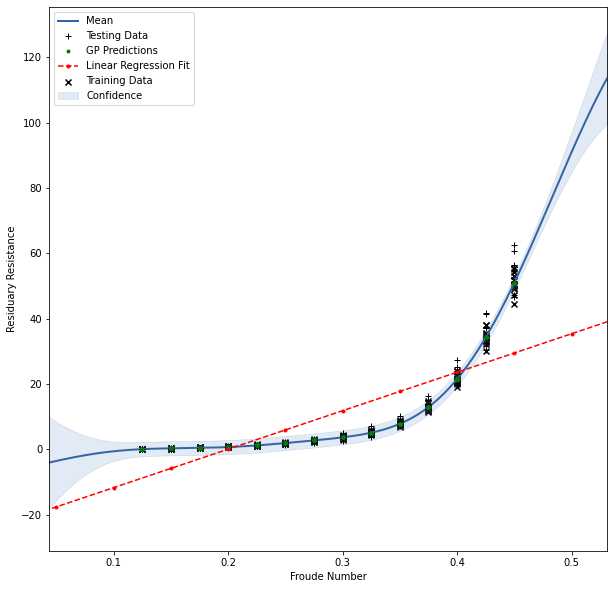

In [10]:
import pylab as plt
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gp_model.plot_data(ax=ax, label='Training Data')
gp_model.plot(ax=ax, plot_data=False)
ax.plot(x_test, y_test, '+', c='k', label='Testing Data')
ax.plot(x_test, gp_predictions, '.', c='green', label='GP Predictions')
model = LinearRegression().fit(x_train, y_train)
import numpy as np
lr_x = np.arange(0., 0.7, 0.05)
lr_y = model.predict(lr_x[:, None])
ax.plot(lr_x, lr_y, '.--', c='red', label='Linear Regression Fit')
ax.set_xlabel('Froude Number')
ax.set_ylabel(label_column)
plt.legend()
plt.show()

### Interpretation Analysis Model 2

We can see at a glance that the relationship between the label and the most important variable, namely `Froude Number` is nonlinear, and that this nonlinearity is well captured by the RBF-GP regression.

This is also evidenced in our improvability analysis as the `Residual R^2` dropped from 0.61 to 0.12.

Note that the $R^2$ of our RBF-GP regression model is very closed to the theoretical best (i.e. `Univariate Achievable R^2` of `Froude Number`).

## Next Step

The fit achieved so far is great, but as evidenced by the fact that the same value of the `Froude Number` variable can result in a wide range of outputs for large froude numbers, and by the non-negligible `Residual R^2`, there is still some ambiguity that might be alleviated with additional inputs.

We could look at fitting another model on the residuals of our RBF-GP regression, and carry on iterating additively until the model improvability analysis suggests that residuals are independent from inputs.